In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
import common
from models import LeNet_300_100, Conv2
from experiment import Experiment

In [4]:
np.random.seed(common.SEED)
torch.manual_seed(common.SEED)

In [19]:
def compare_pruning(e, criterion, layer, n_rounds, pruning_ratio, *, save_results=False):
    print("Random pruning experiment:\n")
    exp_acc, _ = e.random_pruning_rounds(criterion, layer, n_rounds, pruning_ratio, save_results=save_results)   
    print("\nMaximizing frame potential:\n")
    e.init_model()
    max_fp_acc, _ = e.prune_and_test(criterion, layer, pruning_ratio, prune_on_fp=True, 
                                                     increase_fp=True, save_results=save_results)
    print("\nMinimizing frame potential:\n")
    e.init_model()
    min_fp_acc, _ = e.prune_and_test(criterion, layer, pruning_ratio, prune_on_fp=True, 
                                                     increase_fp=False, save_results=save_results)
    return exp_acc, max_fp_acc, min_fp_acc

In [30]:
def draw_plot(layer, exp_acc, max_fp_acc, min_fp_acc, *, figsize=(25,12), fig_name=""):
    plt.figure(figsize=figsize)
    plt.plot(max_fp_acc, label="Max-FP pruning")
    
    exp_acc = np.array(exp_acc)
    random_accuracies = exp_acc.mean(axis=0)
    random_std_devs = exp_acc.std(axis=0)
    plt.errorbar(range(len(max_fp_acc)), random_accuracies, random_std_devs, linestyle='None', 
                 marker='.', label="Random pruning")
    
    plt.plot(min_fp_acc, label= "Min-FP pruning")
    
    plt.title("Accuracy after pruning " + layer)
    elem_type = "neurons" if layer[:2] == "fc" else "filters"
    plt.xlabel("Pruned " + elem_type)
    plt.ylabel("Accuracy (%)")
    plt.legend(loc="best")
    
    if fig_name:
        fig_path = os.path.join(common.FIGURE_PATH, fig_name)
        plt.savefig(fig_path)
    else:
        plt.show()

## MNIST / Lenet 300-100-10

In [5]:
train_batch_size = 64
test_batch_size = 1000

In [6]:
# Move to data.py

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                          download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False, 
                         download=True, transform=transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}  # necessary?

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                           shuffle=True, **kwargs)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                          shuffle=True, **kwargs)


classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [7]:
epochs = 50
lr = 0.003
momentum = 0.9

In [8]:
model = LeNet_300_100()
e = Experiment(trainloader, testloader, model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
monitored = ['fc1', 'fc2', 'fc3']

In [9]:
test_accuracies, frame_potentials = e.fit(epochs, criterion, optimizer, monitored=monitored, save_results=True)


Test set: Average loss: 2.3126, Accuracy:    981/ 10000 (10%)

Train Epoch:   1 [     0/ 60000 (0%)]	Loss: 2.297517
Train Epoch:   1 [  6400/ 60000 (11%)]	Loss: 0.776636
Train Epoch:   1 [ 12800/ 60000 (21%)]	Loss: 0.371301
Train Epoch:   1 [ 19200/ 60000 (32%)]	Loss: 0.302402
Train Epoch:   1 [ 25600/ 60000 (43%)]	Loss: 0.183424
Train Epoch:   1 [ 32000/ 60000 (53%)]	Loss: 0.268265
Train Epoch:   1 [ 38400/ 60000 (64%)]	Loss: 0.229609
Train Epoch:   1 [ 44800/ 60000 (75%)]	Loss: 0.292853
Train Epoch:   1 [ 51200/ 60000 (85%)]	Loss: 0.223220
Train Epoch:   1 [ 57600/ 60000 (96%)]	Loss: 0.225943

Test set: Average loss: 0.2305, Accuracy:   9294/ 10000 (93%)

Train Epoch:   2 [     0/ 60000 (0%)]	Loss: 0.248529
Train Epoch:   2 [  6400/ 60000 (11%)]	Loss: 0.100980
Train Epoch:   2 [ 12800/ 60000 (21%)]	Loss: 0.518315
Train Epoch:   2 [ 19200/ 60000 (32%)]	Loss: 0.162574
Train Epoch:   2 [ 25600/ 60000 (43%)]	Loss: 0.204296
Train Epoch:   2 [ 32000/ 60000 (53%)]	Loss: 0.182096
Train Epoc

Train Epoch:  14 [ 38400/ 60000 (64%)]	Loss: 0.011307
Train Epoch:  14 [ 44800/ 60000 (75%)]	Loss: 0.014324
Train Epoch:  14 [ 51200/ 60000 (85%)]	Loss: 0.002269
Train Epoch:  14 [ 57600/ 60000 (96%)]	Loss: 0.009235

Test set: Average loss: 0.0676, Accuracy:   9796/ 10000 (98%)

Train Epoch:  15 [     0/ 60000 (0%)]	Loss: 0.012217
Train Epoch:  15 [  6400/ 60000 (11%)]	Loss: 0.009298
Train Epoch:  15 [ 12800/ 60000 (21%)]	Loss: 0.003351
Train Epoch:  15 [ 19200/ 60000 (32%)]	Loss: 0.016323
Train Epoch:  15 [ 25600/ 60000 (43%)]	Loss: 0.012470
Train Epoch:  15 [ 32000/ 60000 (53%)]	Loss: 0.008508
Train Epoch:  15 [ 38400/ 60000 (64%)]	Loss: 0.002910
Train Epoch:  15 [ 44800/ 60000 (75%)]	Loss: 0.004058
Train Epoch:  15 [ 51200/ 60000 (85%)]	Loss: 0.026527
Train Epoch:  15 [ 57600/ 60000 (96%)]	Loss: 0.009602

Test set: Average loss: 0.0665, Accuracy:   9796/ 10000 (98%)

Train Epoch:  16 [     0/ 60000 (0%)]	Loss: 0.006045
Train Epoch:  16 [  6400/ 60000 (11%)]	Loss: 0.014475
Train Epoc

Train Epoch:  28 [ 12800/ 60000 (21%)]	Loss: 0.001710
Train Epoch:  28 [ 19200/ 60000 (32%)]	Loss: 0.005970
Train Epoch:  28 [ 25600/ 60000 (43%)]	Loss: 0.001615
Train Epoch:  28 [ 32000/ 60000 (53%)]	Loss: 0.004596
Train Epoch:  28 [ 38400/ 60000 (64%)]	Loss: 0.001083
Train Epoch:  28 [ 44800/ 60000 (75%)]	Loss: 0.003696
Train Epoch:  28 [ 51200/ 60000 (85%)]	Loss: 0.000999
Train Epoch:  28 [ 57600/ 60000 (96%)]	Loss: 0.001077

Test set: Average loss: 0.0674, Accuracy:   9814/ 10000 (98%)

Train Epoch:  29 [     0/ 60000 (0%)]	Loss: 0.001880
Train Epoch:  29 [  6400/ 60000 (11%)]	Loss: 0.001712
Train Epoch:  29 [ 12800/ 60000 (21%)]	Loss: 0.003225
Train Epoch:  29 [ 19200/ 60000 (32%)]	Loss: 0.001009
Train Epoch:  29 [ 25600/ 60000 (43%)]	Loss: 0.001965
Train Epoch:  29 [ 32000/ 60000 (53%)]	Loss: 0.001297
Train Epoch:  29 [ 38400/ 60000 (64%)]	Loss: 0.001730
Train Epoch:  29 [ 44800/ 60000 (75%)]	Loss: 0.003127
Train Epoch:  29 [ 51200/ 60000 (85%)]	Loss: 0.005316
Train Epoch:  29 [ 

Train Epoch:  41 [ 57600/ 60000 (96%)]	Loss: 0.000620

Test set: Average loss: 0.0723, Accuracy:   9822/ 10000 (98%)

Train Epoch:  42 [     0/ 60000 (0%)]	Loss: 0.000934
Train Epoch:  42 [  6400/ 60000 (11%)]	Loss: 0.000729
Train Epoch:  42 [ 12800/ 60000 (21%)]	Loss: 0.000921
Train Epoch:  42 [ 19200/ 60000 (32%)]	Loss: 0.000907
Train Epoch:  42 [ 25600/ 60000 (43%)]	Loss: 0.001151
Train Epoch:  42 [ 32000/ 60000 (53%)]	Loss: 0.000622
Train Epoch:  42 [ 38400/ 60000 (64%)]	Loss: 0.001053
Train Epoch:  42 [ 44800/ 60000 (75%)]	Loss: 0.000861
Train Epoch:  42 [ 51200/ 60000 (85%)]	Loss: 0.000481
Train Epoch:  42 [ 57600/ 60000 (96%)]	Loss: 0.000687

Test set: Average loss: 0.0730, Accuracy:   9821/ 10000 (98%)

Train Epoch:  43 [     0/ 60000 (0%)]	Loss: 0.001083
Train Epoch:  43 [  6400/ 60000 (11%)]	Loss: 0.000644
Train Epoch:  43 [ 12800/ 60000 (21%)]	Loss: 0.000180
Train Epoch:  43 [ 19200/ 60000 (32%)]	Loss: 0.001373
Train Epoch:  43 [ 25600/ 60000 (43%)]	Loss: 0.001025
Train Epoc

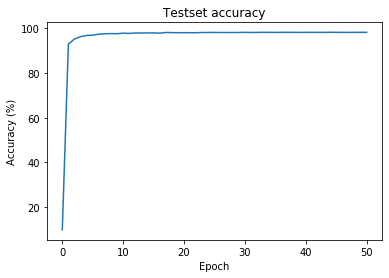

In [10]:
plt.plot(test_accuracies)
plt.title('Testset accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

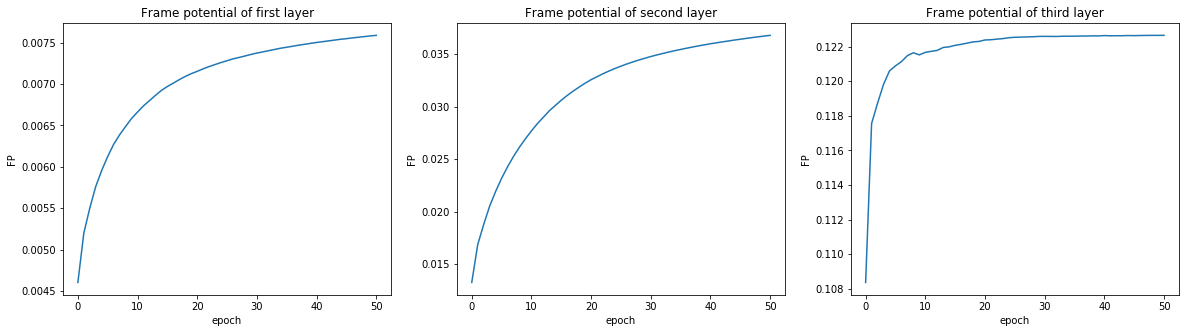

In [11]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex=True, figsize=(20,5))
ax1.plot(frame_potentials['fc1'])
ax1.set_title('Frame potential of first layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['fc2'])
ax2.set_title('Frame potential of second layer')
ax2.set(xlabel='epoch', ylabel='FP')
ax3.plot(frame_potentials['fc3'])
ax3.set_title('Frame potential of third layer')
ax3.set(xlabel='epoch', ylabel='FP')

In [33]:
model_name = "LeNet_300_100_01-10-2019_10:13:45"
criterion = nn.CrossEntropyLoss()
layer = "fc1"
n_rounds = 4
pruning_ratio = 0.02

In [34]:
e = Experiment(trainloader, testloader, LeNet_300_100(), model_name=model_name)
exp_acc, max_fp_acc, min_fp_acc = compare_pruning(e, criterion, layer, n_rounds, pruning_ratio, save_results=False)

Random pruning experiment:

Random pruning experiment N° 1

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0750, Accuracy:   9816/ 10000 (98%)


Test set: Average loss: 0.0768, Accuracy:   9810/ 10000 (98%)


Test set: Average loss: 0.0785, Accuracy:   9801/ 10000 (98%)


Test set: Average loss: 0.0780, Accuracy:   9799/ 10000 (98%)


Test set: Average loss: 0.0776, Accuracy:   9798/ 10000 (98%)


Test set: Average loss: 0.0779, Accuracy:   9794/ 10000 (98%)

Random pruning experiment N° 2

Test set: Average loss: 0.0747, Accuracy:   9821/ 10000 (98%)


Test set: Average loss: 0.0747, Accuracy:   9817/ 10000 (98%)


Test set: Average loss: 0.0761, Accuracy:   9815/ 10000 (98%)


Test set: Average loss: 0.0777, Accuracy:   9809/ 10000 (98%)


Test set: Average loss: 0.0825, Accuracy:   9799/ 10000 (98%)


Test set: Average loss: 0.0799, Accuracy:   9801/ 10000 (98%)


Test set: Average loss: 0.0798, Accuracy:   9801/ 10000 (98%)

Random pruning

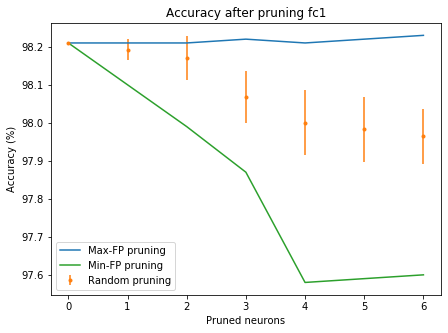

In [38]:
draw_plot(layer, exp_acc, max_fp_acc, min_fp_acc, figsize=(7,5), fig_name="")

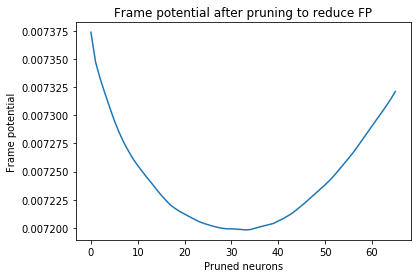

In [29]:
plt.plot(frame_potentials['fc1'])
plt.title('Frame potential after pruning to reduce FP')
plt.xlabel('Pruned neurons')
plt.ylabel('Frame potential')
plt.show()

#### Show images, compare class results

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [7]:
print(images.shape)
print(labels.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [0]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%9s' % classes[predicted[j]]
                              for j in range(4)))

Predicted: 
         7         2         1         0


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 : 98 %
Accuracy of 1 : 97 %
Accuracy of 2 : 89 %
Accuracy of 3 : 96 %
Accuracy of 4 : 100 %
Accuracy of 5 : 92 %
Accuracy of 6 : 94 %
Accuracy of 7 : 96 %
Accuracy of 8 : 98 %
Accuracy of 9 : 97 %


## CIFAR-10 / Conv-2

In [39]:
train_batch_size = 64
test_batch_size = 1000

In [40]:
# Move to data.py

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}  # necessary?

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, **kwargs)

testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=True, **kwargs)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [41]:
epochs = 20
lr = 0.0002

In [9]:
model = Conv2()
e = Experiment(trainloader, testloader, model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
monitored = ['conv1', 'conv2', 'fc1', 'fc2']

In [10]:
test_accuracies, frame_potentials = e.fit(epochs, criterion, optimizer, monitored=monitored, save_results=False)


Test set: Average loss: 2.3042, Accuracy:    990/ 10000 (10%)

Train Epoch:   1 [     0/ 50000 (0%)]	Loss: 2.309030
Train Epoch:   1 [  6400/ 50000 (13%)]	Loss: 1.742888
Train Epoch:   1 [ 12800/ 50000 (26%)]	Loss: 1.389441
Train Epoch:   1 [ 19200/ 50000 (38%)]	Loss: 1.221832
Train Epoch:   1 [ 25600/ 50000 (51%)]	Loss: 1.265922
Train Epoch:   1 [ 32000/ 50000 (64%)]	Loss: 1.124998
Train Epoch:   1 [ 38400/ 50000 (77%)]	Loss: 1.327337
Train Epoch:   1 [ 44800/ 50000 (90%)]	Loss: 1.221110

Test set: Average loss: 1.1754, Accuracy:   5812/ 10000 (58%)

Train Epoch:   2 [     0/ 50000 (0%)]	Loss: 1.117527
Train Epoch:   2 [  6400/ 50000 (13%)]	Loss: 0.990872
Train Epoch:   2 [ 12800/ 50000 (26%)]	Loss: 1.152403
Train Epoch:   2 [ 19200/ 50000 (38%)]	Loss: 0.908521
Train Epoch:   2 [ 25600/ 50000 (51%)]	Loss: 1.022519
Train Epoch:   2 [ 32000/ 50000 (64%)]	Loss: 0.883264
Train Epoch:   2 [ 38400/ 50000 (77%)]	Loss: 0.807983
Train Epoch:   2 [ 44800/ 50000 (90%)]	Loss: 0.735661

Test set:

[Text(0, 0.5, 'FP'), Text(0.5, 0, 'epoch')]

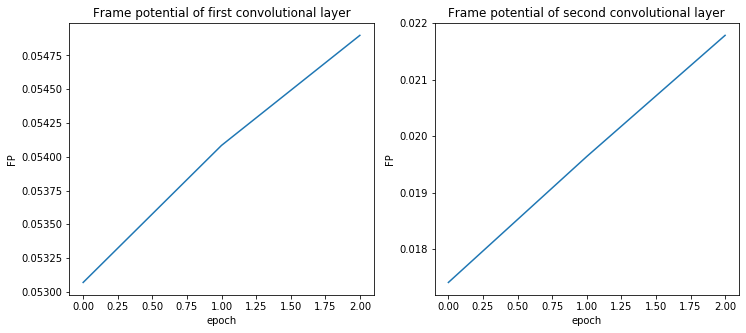

In [11]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, figsize=(12,5))
ax1.plot(frame_potentials['conv1'])
ax1.set_title('Frame potential of first convolutional layer')
ax1.set(xlabel='epoch', ylabel='FP')
ax2.plot(frame_potentials['conv2'])
ax2.set_title('Frame potential of second convolutional layer')
ax2.set(xlabel='epoch', ylabel='FP')

In [43]:
model_name = "Conv2_01-10-2019_12:37:35"
criterion = nn.CrossEntropyLoss()
layer = "conv1"
n_rounds = 4
pruning_ratio = 0.1

In [44]:
e = Experiment(trainloader, testloader, Conv2(), model_name=model_name)
exp_acc, max_fp_acc, min_fp_acc = compare_pruning(e, criterion, layer, n_rounds, pruning_ratio, save_results=False)

Random pruning experiment:

Random pruning experiment N° 1

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2180, Accuracy:   6930/ 10000 (69%)


Test set: Average loss: 2.2054, Accuracy:   6889/ 10000 (69%)


Test set: Average loss: 2.2518, Accuracy:   6807/ 10000 (68%)


Test set: Average loss: 2.1670, Accuracy:   6840/ 10000 (68%)


Test set: Average loss: 2.1055, Accuracy:   6837/ 10000 (68%)


Test set: Average loss: 2.0967, Accuracy:   6821/ 10000 (68%)

Random pruning experiment N° 2

Test set: Average loss: 2.2412, Accuracy:   6966/ 10000 (70%)


Test set: Average loss: 2.2146, Accuracy:   6960/ 10000 (70%)


Test set: Average loss: 2.1606, Accuracy:   6946/ 10000 (69%)


Test set: Average loss: 2.1307, Accuracy:   6931/ 10000 (69%)


Test set: Average loss: 2.1125, Accuracy:   6882/ 10000 (69%)


Test set: Average loss: 2.0602, Accuracy:   6858/ 10000 (69%)


Test set: Average loss: 1.9941, Accuracy:   6848/ 10000 (68%)

Random pruning

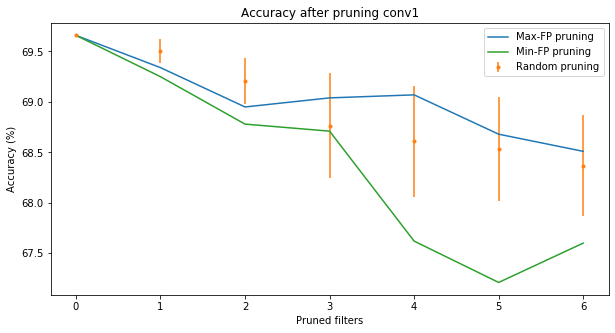

In [45]:
draw_plot(layer, exp_acc, max_fp_acc, min_fp_acc, figsize=(10,5), fig_name="")

#### Show images, compare class results

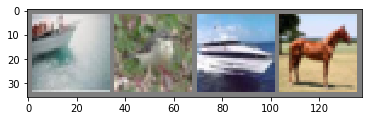

 ship  bird  ship horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 69 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 52 %
Accuracy of   car : 65 %
Accuracy of  bird : 51 %
Accuracy of   cat : 46 %
Accuracy of  deer : 53 %
Accuracy of   dog : 20 %
Accuracy of  frog : 49 %
Accuracy of horse : 59 %
Accuracy of  ship : 79 %
Accuracy of truck : 57 %
